# Environmental Impact of Agricultural Practices in the World

**ADA Project Milestone 3**

This notebook consists of our complete Data Analysis of the FAOSTAT dataset on Food an agriculture. 

In the previous Milestone, we have studied in detail the contents of the dataset, and restructured it in the appropriate forms, taking care of multiple discrepancies we had encountered. Now that the data is in the appropriate format, we will re-iterate our initial analysis of the data, and then answer all of our research questions.

In [125]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fao_ada.pre_processing.load import load_dataframe
%load_ext autoreload
%autoreload 2

country_groups = load_dataframe("data/country_groups.csv")
country_codes = load_dataframe("data/countries.csv")
population_df = load_dataframe("data_cleaned/population/Population_E_All_Data_(Normalized).csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cleaned_files = glob("data_cleaned/**/*.csv")

Before doing any further step, we would like to check if, in the pre-processed data, we have any discrepancies regarding the mappings of items and elements

In [3]:
from fao_ada.utils import check_mapping_multiple_files
print(check_mapping_multiple_files(cleaned_files, ['itemcode'], ['item']))
print(check_mapping_multiple_files(cleaned_files, ['elementcode'], ['element', 'unit']))

Could not find column itemcode in data_cleaned/environment/Environment_Temperature_change_E_All_Data_(Normalized).csv
True
True


Looks good:
- The mapping itemcode <=> item is unique
- The mapping elementcode <=> (element, unit) is unique

In [4]:
import seaborn as sns
sns.set_palette(sns.color_palette("muted"))
sns.set_style("darkgrid")

---
### 1. What is the overall impact of the agriculture industry on global green house gas (GHG) emissions ?
---

This first question that naturally comes to mind. FAO provides data regarding emissions from multiple sectors. Green house gase emissions are computed using `CO2eq` (i.e. CO2 equivalent) from multiple gases (CO2, CH4, N20, and F-gases), which are in top list of Green House Gases.

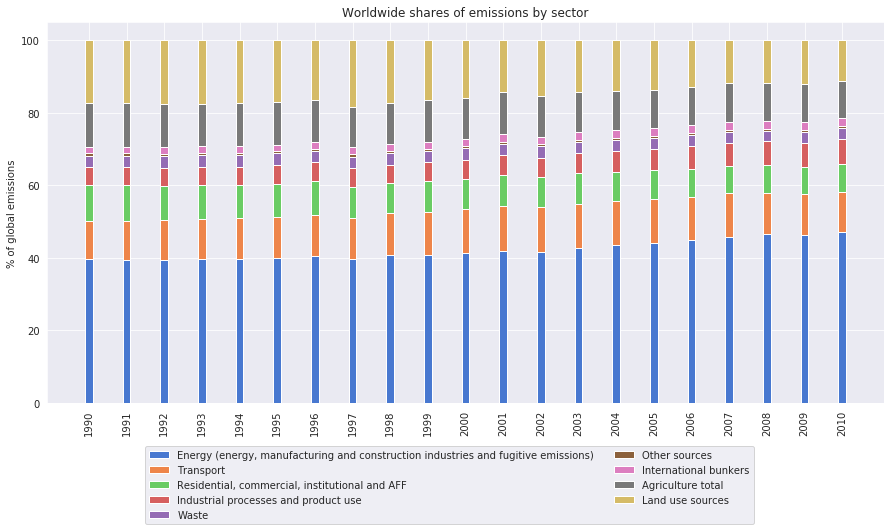

In [41]:
from fao_ada.pre_processing.grouping import groupby_country_groups
from fao_ada.plotting import plot_stacked_bar_single_area_single_element

emissions_by_sector_df = pd.read_csv("data_cleaned/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv")
emissions_by_sector_df = emissions_by_sector_df[emissions_by_sector_df.areacode.isin(country_groups['countrygroupcode'].unique())]

plot_stacked_bar_single_area_single_element(emissions_by_sector_df, elementcode=7263, areacode=5000, title="Worldwide shares of emissions by sector", ylabel="% of global emissions")

It seems that agriculture has stayed around 10% of global emissions by sector for the years 1990-2010. Now we shall look at the share of this emissions for each gas, only looking at the World wide Agriculture emissions.

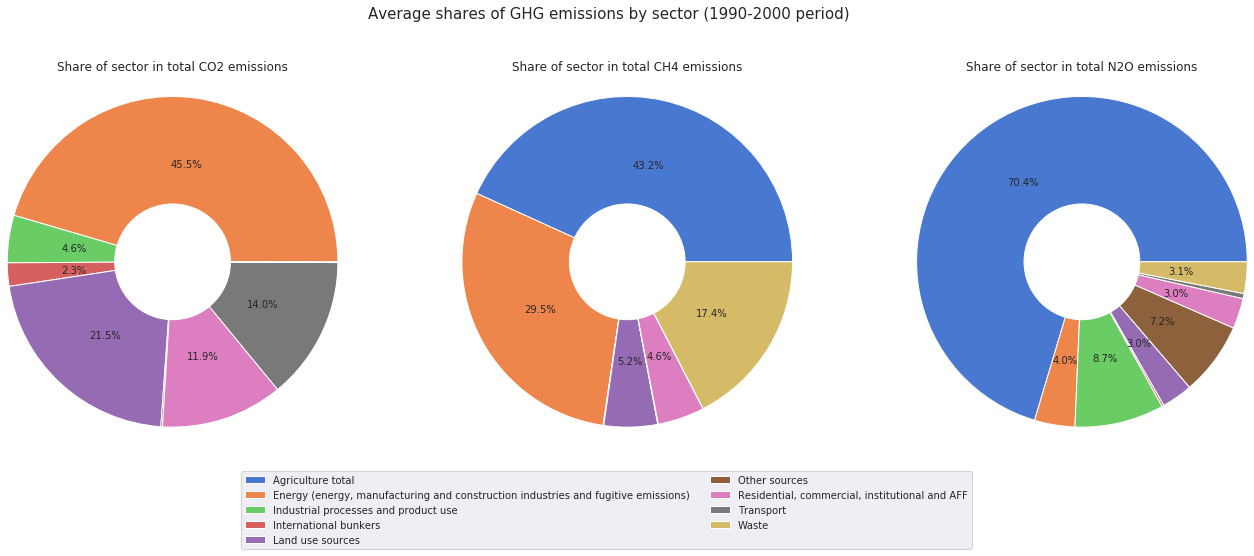

In [16]:
from fao_ada.plotting import plot_elements_pie_single_area
plot_elements_pie_single_area(emissions_by_sector_df, elementcodes=[7264, 7265, 7266], areacode=5000, suptitle="Average shares of GHG emissions by sector (1990-2000 period)")

From this pie chart, we can learn a few things for the Agriculture industry:
 - It seems that direct CO2 emissions from Agriculture are absent (0%). This makes sense as C02 is not directly emitted. However, the CO2 emissions might be indirect, as food is always transported via non carbon-free methods, and industrial machinery is used in agriculture, and requires energy.
 - Global CH4 Emissions are shared between Agriculture and Energy industries, with a majority for Agriculture (41.4%)
 - Global N2O are largely dominated by the Agriculture industry (70%)

All of these gases are considered top level Green House gases. It makes sense now to focus on searching where those emissions come from in detail (only for agriculture), and how can we reduce them without comprimising the diet of the population.

Now we know which GHG are largely emitted by the agriculture industry, and that Agriculture contributes to roughly 10% of global Emissions, but largely dominates other sectors in terms of CH4 and N2O emissions. 

However, this plot does not take into consideration indirect emissions due to Agriculture:
- Emissions due to transport of food (included in "Transport" sector)
- Emissions due to use of energy for producing agricultural products (included in "Energy")

Our analysis focuses more on the direct emissions of Agriculture, and hence we will not take those aspects in consideration as they fall outside of the scope.

---
### 2. What are the sources of CH4 and N2O emissions from in the Agriculture Industry ?
---

To illustrate this, we can separate the emissions of both gases into 10 items related to agriculture: Enteric Fermentation, Manure management, Rice Cultivation, Synthetic Fertilizers, Manure applied to soils, Manure left on Pasture, Crop residues, Burning of crop residues, Burning of savanna and Cultivation of organic Soils.


In [70]:
emissions_agr_df = pd.read_csv("data_cleaned/emissions_agriculture/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv")
emissions_agr_df_grp = groupby_country_groups(emissions_agr_df, country_groups)
emissions_agr_df_grp = emissions_agr_df_grp[emissions_agr_df_grp.year < 2020]


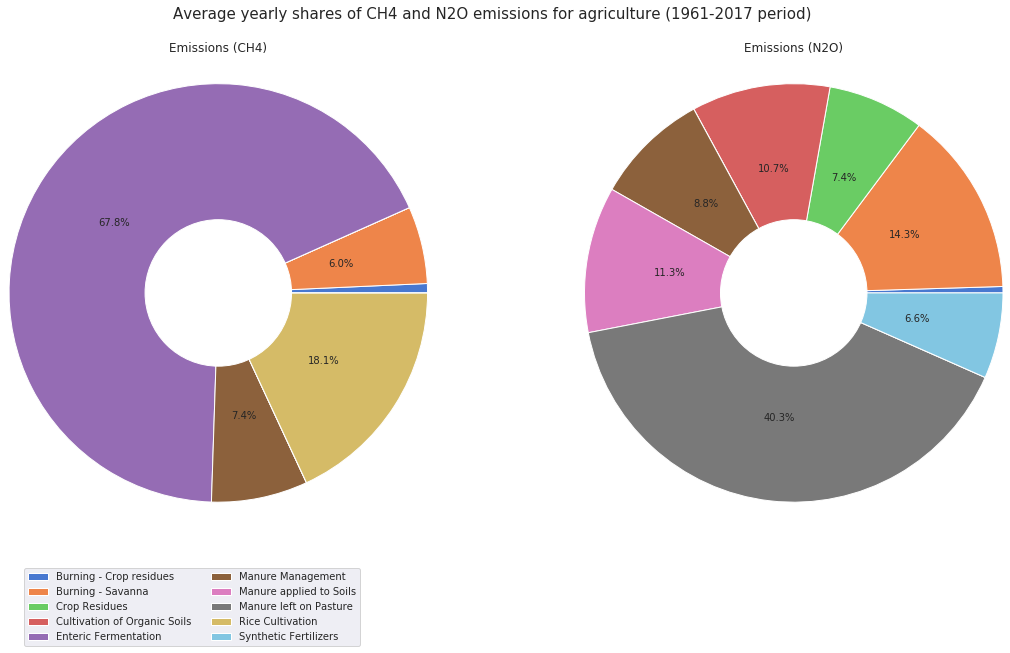

In [71]:
plot_elements_pie_single_area(emissions_agr_df_grp, [7225, 7230], 5000, "Average yearly shares of CH4 and N2O emissions for agriculture (1961-2017 period)", figsize=(15, 10), y_title=0.9)

This pie chart illustrates quite well the origin of emissions of CH4 and N2O, in the agriculture industry. Before interpreting the chart, let's brievly explain what each item represents:
- Burning - Crop residues: Agricultural practice that consists of combusting a percentage of crop residues on site
- Burning - Savanna: Periodic prescribed burning of savanna for agricultural purposes
- Enteric Fermentation: Digestive process by which carbohydrates are broken down by micro organisms into simple molecules for absorption into the bloodstream of an animal.
- Manure Management: Refers to capture, storage, treatment, and utilization of animal manure
- Rice Cultivation: Agricultural practice for growing rice seeds
- Crop Resdiues: Agriculture management practice that consists in returning to managed soils the residual part of the produce
- Cultivation of Organic Soils:
- Manure applied to Soils: Animal waste distributed on fields in amounts that enrich soils
- Manure left on pasture: Animal waste left on managed soils from grazing livestock. 
- Synthetic Fertilizers: Inorganic material of synthetic origin added to a soil to supply one or more plant nutrients essential to the growth of plants.

1. CH4 Emissions:

    - Direct CH4 emissions of agriculture are mostly dominated by the Enteric Fermentation of Livestock (69.4%), which means that this particular source of emissions accounts for rougly 30% of the global CH4 Emissions, which is quite significant.
    - Rice Cultivation also is a big contributor (18%) to the emissions of this GHG.
    - Other sources have much lower contribution to emissions of this gas
    

2. N2O Emissions:
    - The biggest contributor is "Manure Left on Pasture", followed by Synthetic Fertilizers.
    - The use of Manure (Manure management, left on pasture, and applied to soils) have a contribution of roughly 40% (together) of N2O Emissions for agriculture.

---
### 3. How have global emissions of those gases from each source evolved in the past years ?
---
Having an average share of each source over the past 50 years gives us a general idea of where the emissions come from. Additionally, the evolution of emissions in this time frame is also interesting.

We all know Global emissions have increased worldwide, but what are the sources of this increase in the agricultural sector ?

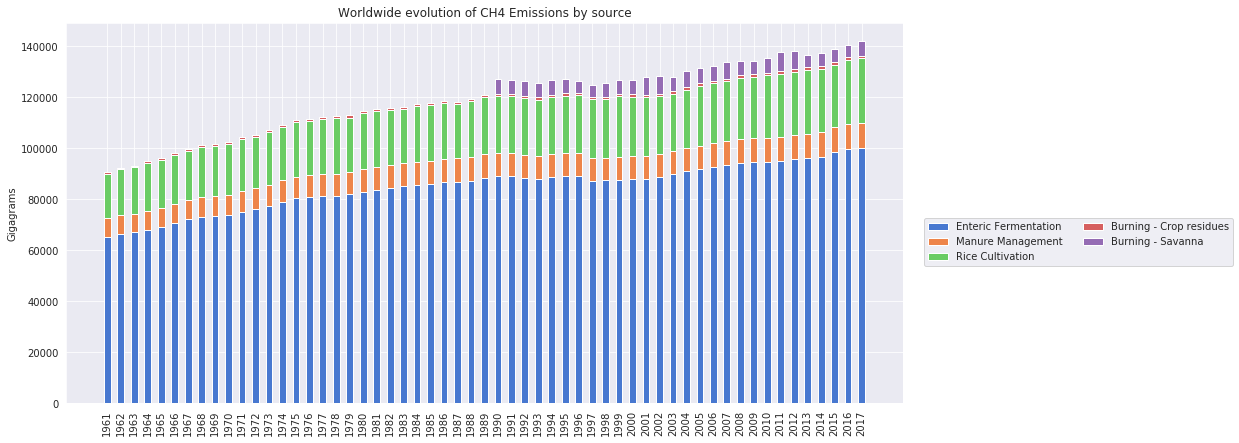

In [72]:
plot_stacked_bar_single_area_single_element(emissions_agr_df_grp, elementcode=7225, areacode=5000, title="Worldwide evolution of CH4 Emissions by source", ylabel="Gigagrams", bbox=(1.4, 0.5), width=0.5)

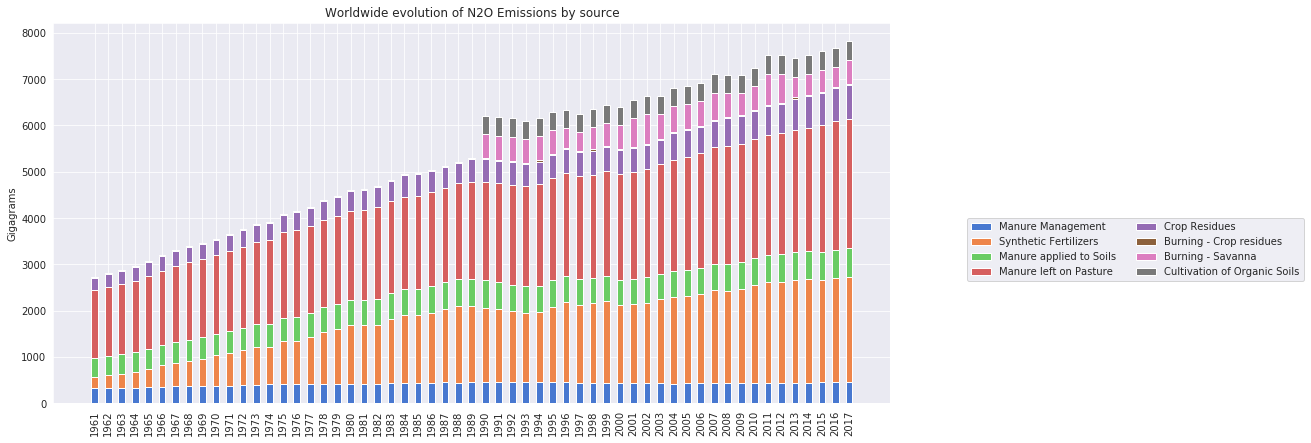

In [73]:
plot_stacked_bar_single_area_single_element(emissions_agr_df_grp, elementcode=7230, areacode=5000, title="Worldwide evolution of N2O Emissions by source", ylabel="Gigagrams", bbox=(1.5, 0.5), width=0.5)

We can notice a clear linear increase in the emission of both gases , with a slight peak in 1990-1995. This is most probably due to previously missing data, as we can see that some items only start appearing around that period of time.

#### 1. Emissions of CH4:

As seen previously, we knew that CH4 emissions are dominated by the Enteric Fermentation, and we can see that it has increased by roughly 50% since 1961. However other sources do not seem to have had the same increase in emissions.

#### 2. Emissions of N2O:
Increases here are more interesting. We can see that emissions due to Synthetic fertilizers have increased linearly by almost 400%, with slightly lower steepness after ~1995. 
Manure Management's emissions also increased linearly.

---
### 4. Which countries contribute the most to emissions due to agriculture ?
---

We now have a global view on emissions worldwide, but it would be interesting to have a more detailed approach and see which countries countribute the most to the emissions of those 2 gases.

#### 1. Raw data
First we plot the total emissions in gigagrams for each country and gas (for CH4 and N2O) as a heatmap.

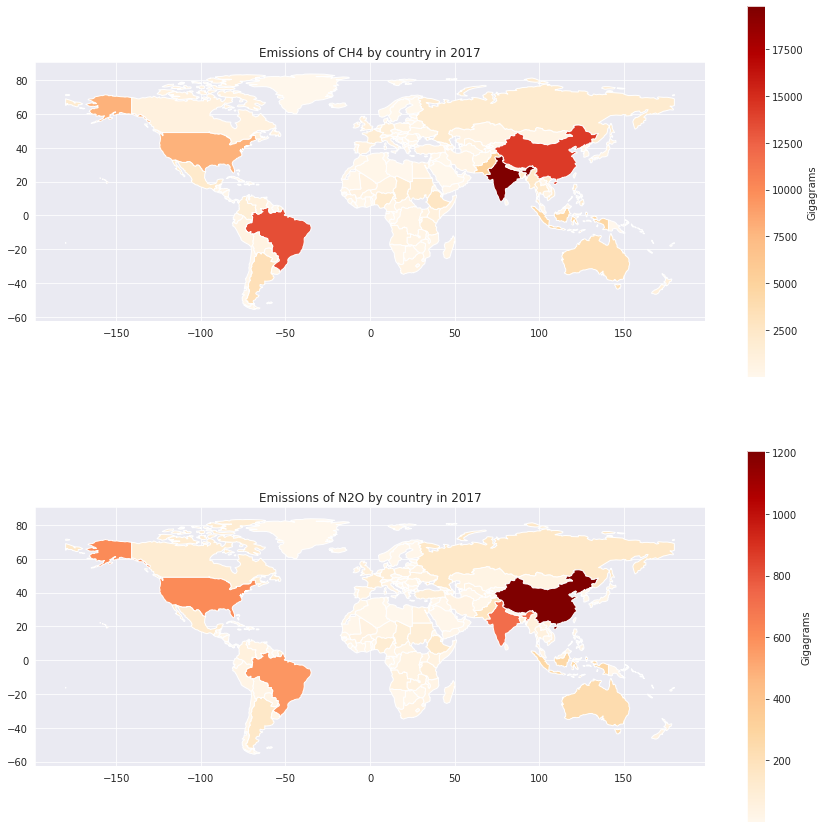

In [91]:
from fao_ada.plotting import plot_maps

SHAPE_FILE = "data/gpd_maps/ne_110m_admin_0_countries.shp"
titles = {7225: "Emissions of CH4 by country in 2017", 7230: "Emissions of N2O by country in 2017"}
plot_maps(emissions_agr_df, [7225, 7230], country_codes, 2017, SHAPE_FILE, titles=titles)

It looks like 4-5 countries contribute much more than others to emissions of the two gases: China, India, United States, Brazil and Australia. However, these countries' populations are quite signifcant. Let's look at the same graph, but after normalizing by population.

#### 2. Normalized by population


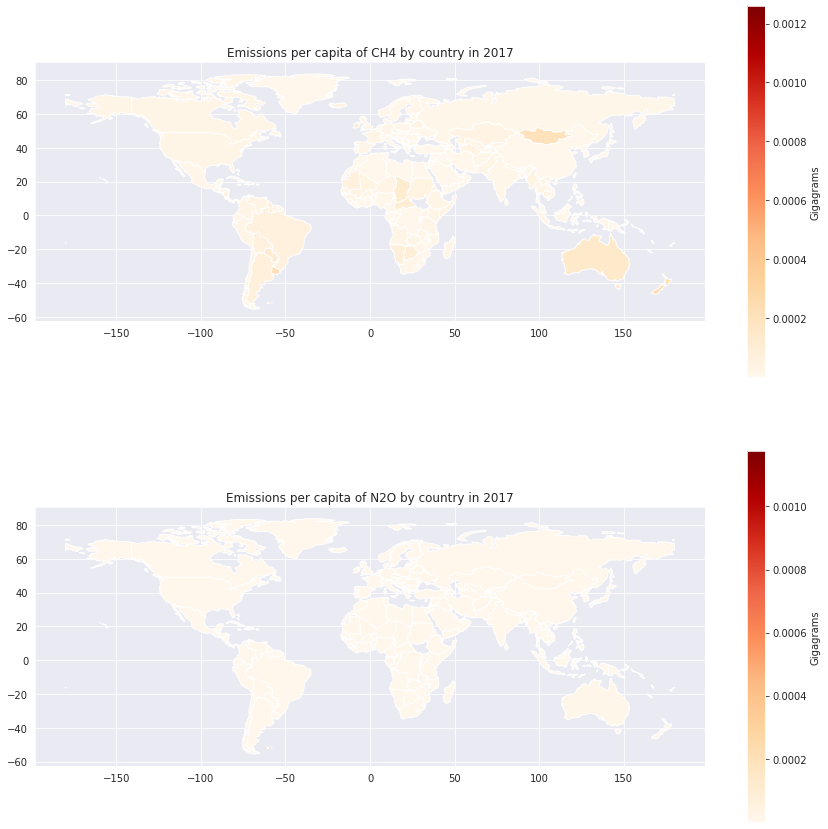

In [113]:
from fao_ada.utils import normalize_by_population
from fao_ada.pre_processing.grouping import groupby_all_items_sum
titles = {7225: "Emissions per capita of CH4 by country in 2017", 7230: "Emissions per capita of N2O by country in 2017"}

emissions_agr_df_norm = normalize_by_population(groupby_all_items_sum(emissions_agr_df), population_df)
plot_maps(emissions_agr_df_norm, [7225, 7230], country_codes, 2017, SHAPE_FILE, titles=titles)

At a first glance, it seems that all countries have similar values of emission gigagrams/capita, but the scale tells us that some countries have higher values. Let's plot the distribution of values and check how it behaves.

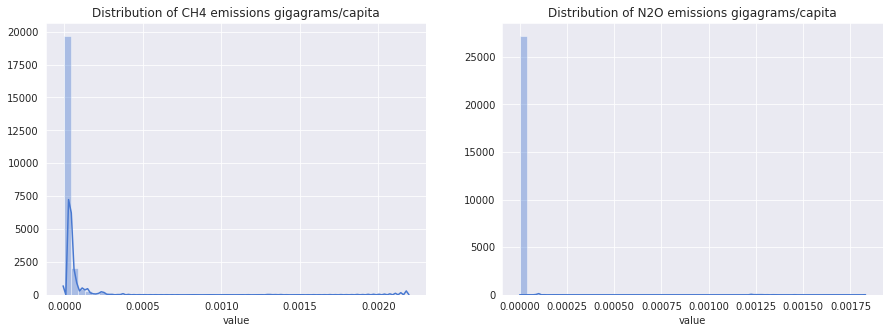

In [127]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
tmp1 = emissions_agr_df_norm[emissions_agr_df_norm.elementcode == 7225]
tmp2 = emissions_agr_df_norm[emissions_agr_df_norm.elementcode == 7230]
sns.distplot(tmp1['value'].dropna(), ax=ax[0])
ax[0].set_title("Distribution of CH4 emissions gigagrams/capita")
sns.distplot(tmp2['value'].dropna(), ax=ax[1])
ax[1].set_title("Distribution of N2O emissions gigagrams/capita");


The values seem to be very concentrated around 0, but both distributions have a very long tail. This could be due to a faulty value for one or a couple of countries.

After further inspection, we saw that one country seems to stand out and has a much higher value: Falkland Islands, a small group of islands in the southern Atlantic, with a population of around 3000 people. These islands seem to have a quite high livestock/capita ratio, according to their website [Falkland Government Website](https://www.fig.gov.fk/agriculture/publications/farming-stastics/category/27-farming-statistics-2016-to-2020). For visualization purposes, we will drop this line and replot the maps.

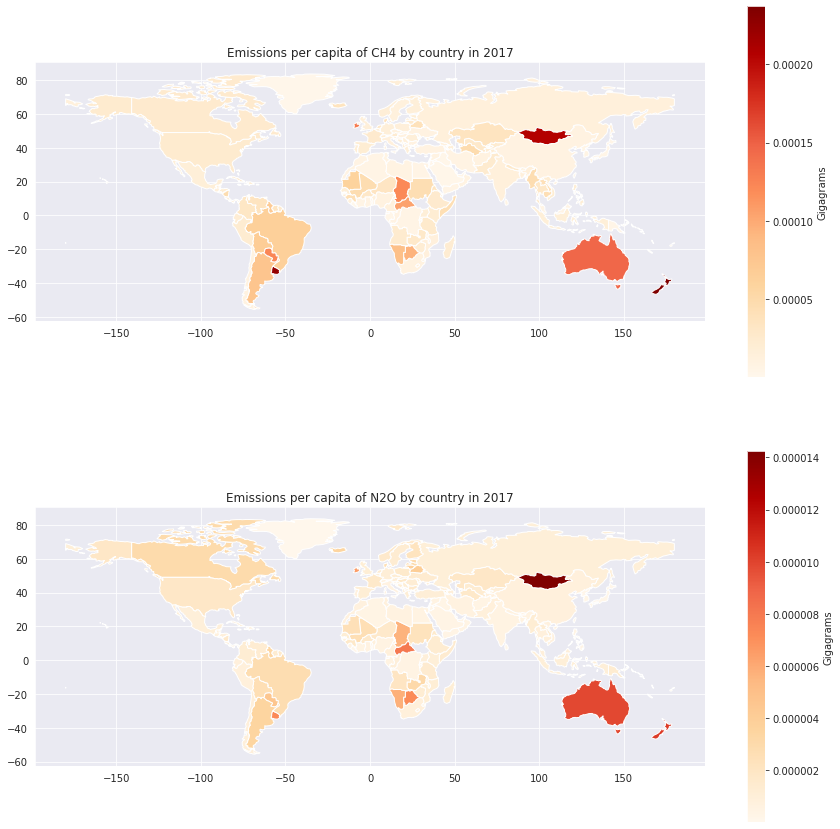

In [138]:
plot_maps(emissions_agr_df_norm[emissions_agr_df_norm.areacode != 65], [7225, 7230], country_codes, 2017, SHAPE_FILE, titles=titles)

The map looks much better now. We can see which countries stand out: Australia and Mongolia seem to have a very high emission factor per capita for both gases.

---
### 5. Which crops/livestock production has increased during that time frame ? And is the increase linear with the increase of population ?
---

We will now shift our focus to production of various crops and livestock. The data is separated in 3 categories: Livestock (live animals), Livestock produce (meat, eggs, etc..) and Crops.